# Calculating the longitudinal field and False Alarm Probability

The calculation of the longitudinal magnetic field (Bz) from a Stokes V line profile is done using:

$$B_{z} = \frac{-1}{g_\mathrm{eff} \ell_{\mathrm{const}} \lambda_o c}\frac{\int vV(v)dv}{\int (1-I(v))dv},$$

where $I(v)$ and $V(v)$ are the continuum normalized $I/I_c$ and $V/I_c$, $v$ is the velocity relative to the center of the line, and

$$\ell_{\mathrm{const}} = \frac{e}{4\pi m_e c^2} \approx 4.67\times 10^{-12} ~ \mathrm{nm}^{-1} \mathrm{G}^{-1}$$

When calculating $B_{z}$ from an LSD profile, the rest wavelength of the line ($\lambda_o$) and effective Landé factor ($g_\mathrm{eff}$) should be the normalizing values used in the LSD calculation.

Note that the `calc_bz` function of the LSD Class presented here requires $\lambda_o$ to be given in nanometers.

We also compute the False Alarm Probability (FAP) of a signal in Stokes V and the null profile, over the same velocity range used in the Bz calculation. The FAP is the p-value for the probability that the observed Stokes V, or null, profile is consistent with just noise.  More specifically, it is the probability that a model consisting of a flat line is consistent with the observations, based on $\chi^2$.  When reporting a detection of a signaly based on the FAP, typically:
* For a definitive detection, FAP < $10^{-4}$
* For a marginal detection, FAP < $10^{-2}$

Although different sources may used slightly different thresholds, and it can be helpful to adopt more conservative criteria when dealing with large numbers of stars.

## 1. Example with one LSD profile

First import specpolFlow and any other packages

In [1]:
import specpolFlow as pol

import pandas as pd

We load an example LSD profile ([SampleLSD.lsd](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/Tutorials/CalculateBz_tutorialfiles/SampleLSD.lsd)) and use the built-in plotting routine to visualize the Stokes V, null, and I profiles.

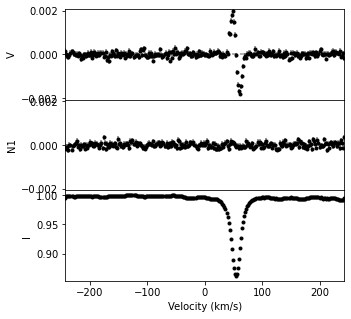

In [2]:
lsd = pol.read_lsd('CalculateBz_tutorialfiles/SampleLSD.lsd')
fig, ax = lsd.plot(figsize=(5,5))

To calculate Bz, we call the <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>calc_bz</a> function of the LSD object. The result is returned as a Python dictionary.  

When using `calc_bz` you must provide the effective Landé factor (`geff`) and rest wavelength (`lambda0`) for the calculation. In general these should be the normalizing values used for calculating the LSD profile.

In this example, we set the `velrange` option to [0, 100] -- this range is used to calculate the center-of-gravity (cog) of the profile, with the `cog='I'` method. The LSD profile *outside* of velrange is used to calculate the continuum level, because `norm='auto'` (this is the default option). The <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>calc_bz</a> docs list alternative options for calculating the cog.

The Bz is then calculated by integrating over a range `bzwidth=25.0` km/s on each side of the cog. The `bzwidth` can be omitted, and then the integration range is taken from `velrange`.  And `bzwidth` can be a pair of values (e.g. `bzwidth=[27., 23.]`) to use an asymmetrical integration range, although this is usually a bad idea.

In this example, we have the Bz routine display a diagnostic graph. This can be very useful for ensuring that `velrange`, and optionally `bzwidth`, have correct values. In general, the value of Bz is sensitive to the chosen integration range.

NOTE: In LSD profiles that do not have a Null2 column, the LSD class replaces N2 with zeros, which means that the N2 Bz will also be set to zero.

using AUTO method for the normalization
  using the median of the continuum outside of the line
{'Ic': 0.99703, 'cog': 53.3592394550717, 'Bzwidth min': 28.3592394550717, 'Bzwidth max': 78.3592394550717, 'V bz (G)': 94.17678426512535, 'V bz sig (G)': 6.2520241712455595, 'V FAP': 0.0, 'N1 bz (G)': 4.858516305698941, 'N1 bz sig (G)': 6.122939627225724, 'N1 FAP': 0.76106309449015, 'N2 bz (G)': 0.0, 'N2 bz sig (G)': 0.0, 'N2 FAP': 0.0}
for V: Bz = 94.17678426512535 +/- 6.2520241712455595 G (FAP 0.0)
for N: Bz = 4.858516305698941 +/- 6.122939627225724 G (FAP 0.76106309449015)


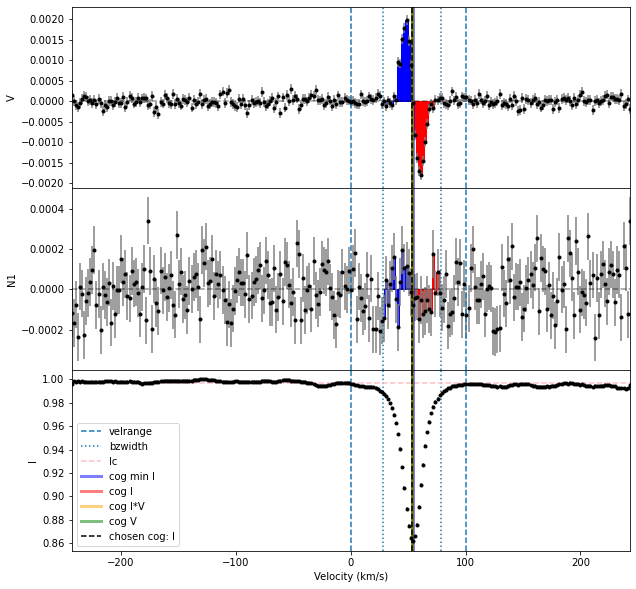

In [3]:
Bz, fig = lsd.calc_bz(cog='I', norm='auto', 
                      geff=1.2, lambda0=500.0,
                      velrange=[0.0, 100.0], bzwidth=25.0, 
                      plot=True)
print(Bz)
#To print some more important outputs from the dictionary:
print('for V: Bz = {:} +/- {:} G (FAP {:})'.format(Bz['V bz (G)'], Bz['V bz sig (G)'], Bz['V FAP']))
print('for N: Bz = {:} +/- {:} G (FAP {:})'.format(Bz['N1 bz (G)'], Bz['N1 bz sig (G)'], Bz['N1 FAP']))

The dictionary returned by `calc_bz` can be directly converted to a Pandas dataframe.  This can be convenient for saving or displaying results. 

In [4]:
Bz = pd.DataFrame(data=[Bz])

# simple display of the pandas dataframe (for Jupyter Notebooks)
Bz.style

,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,0.997030,53.359239,28.359239,78.359239,94.176784,6.252024,0.000000,4.858516,6.122940,0.761063,0.000000,0.000000,0.000000


## 3. Calculating Bz for multiple LSD profiles. 

When processing multiple LSD profiles, particularly multiple observations of the same star, it can be efficient to loop over a list of LSD profiles.  Then Bz can be calculated for each profile in the loop.  In this example we save the results into a list, and convert the list of dictionaries into pandas dataframe.  Then we add a column to the dataframe with the names of the stars.

In this case, the observations have different radial velocities. So we need to change `velrange` and `bzwidth` for each input file.  If the observations are all for one star, these values can usually be constant.

In [5]:
files = ['CalculateBz_tutorialfiles/SampleLSD.lsd', 
         'CalculateBz_tutorialfiles/SampleLSD2.lsd']
velrange_list = [[10., 95.], [-10., 55.]]
bzwidth_list = [25., 20.]

Bz_list = []
for i, file in enumerate(files):
    # load the LSD profile
    lsd = pol.read_lsd(file)
    # calculate Bz, this time without plotting each profile
    Bz = lsd.calc_bz(cog='I', velrange=velrange_list[i], 
                     bzwidth=bzwidth_list[i], 
                     geff=1.2, lambda0=500.0, plot=False)
    Bz_list += [Bz]
Bz_table = pd.DataFrame(data=Bz_list)

# let's add a column to the table with the filename
Bz_table.insert(0, 'Filename', files, True)
# and you can add a column to the table with more descriptive names 
names = ['star 1', 'star 2']
Bz_table.insert(0, 'Observation', names, True)

# display the table
Bz_table.style

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


,Observation,Filename,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,star 1,CalculateBz_tutorialfiles/SampleLSD.lsd,0.996810,53.617944,28.617944,78.617944,94.584944,6.278508,0.000000,4.848727,6.148771,0.761063,0.000000,0.000000,0.000000
1,star 2,CalculateBz_tutorialfiles/SampleLSD2.lsd,0.995230,22.428587,2.428587,42.428587,32.111990,10.562343,0.002714,-0.484883,10.561599,0.845782,0.000000,0.000000,0.000000


With the results in a Pandas dataframe (see the [Pandas documentation](https://pandas.pydata.org/docs/user_guide/index.html)) we can do several things easily. We can save the table to a file (in this example a text .csv).  We can also extract specific columns or rows from the table.

In [6]:
# save the table to a file
Bz_table.to_csv('CalculateBz_tutorialfiles/BzTable.csv')

In [7]:
# get a row for one observation only:
star2 = Bz_table[Bz_table['Observation']=='star 2']
star2.style

,Observation,Filename,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
1,star 2,CalculateBz_tutorialfiles/SampleLSD2.lsd,0.995230,22.428587,2.428587,42.428587,32.111990,10.562343,0.002714,-0.484883,10.561599,0.845782,0.000000,0.000000,0.000000


In [8]:
# get the columns for the Stokes V Bz value, and its uncertainty
Bz_V = Bz_table[['V bz (G)', 'V bz sig (G)']]
Bz_V.style

,V bz (G),V bz sig (G)
0,94.584944,6.278508
1,32.111990,10.562343


In [9]:
# turn this into a numpy array
arr_Bz_V = Bz_V.to_numpy()
print(arr_Bz_V)

[[94.58494375  6.27850841]
 [32.11198956 10.56234263]]
